In [24]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from matplotlib import pyplot as plt

In [25]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [26]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [27]:
transform = transforms.Compose(
    [
        # transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomCrop(25),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ]
)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True,num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [28]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
    self.norm1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
    self.norm3 = nn.BatchNorm2d(128)
    self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
    self.conv5 = nn.Conv2d(128,256,3, padding=1)
    self.norm5 = nn.BatchNorm2d(256)
    self.conv6 = nn.Conv2d(256,256,5, padding=1)
    self.dropout = nn.Dropout(p=0.05)
    self.fc1 = nn.Linear(256*2*2, 1024)
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 10)
  def forward(self, x):
    x = F.relu(self.norm1(self.conv1(x)))#1
    x = self.pool(F.relu(self.conv2(x)))#2
    x = F.relu(self.norm3(self.conv3(x)))#3
    x = self.dropout(self.pool(F.relu(self.conv4(x))))#4
    x = F.relu(self.norm5(self.conv5(x)))
    x = self.pool(F.relu(self.conv6(x)))
    # print(f"6: {x.shape}")
    x = x.view(-1, 256*2*2)
    x = self.dropout(x)
    x = F.relu(self.fc1(x))
    x = self.dropout(F.relu(self.fc2(x)))
    x = self.fc3(x)
    return x

model = Model()
print(model)

if train_on_gpu:
    model.cuda()

Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout(p=0.05, inplace=False)
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=

In [29]:
# specify loss function
criterion = nn.CrossEntropyLoss()
# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [30]:
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)

In [31]:
print(train_on_gpu)

False


Epoch: 1 	Training Loss: 1.287751
Epoch: 2 	Training Loss: 1.123430


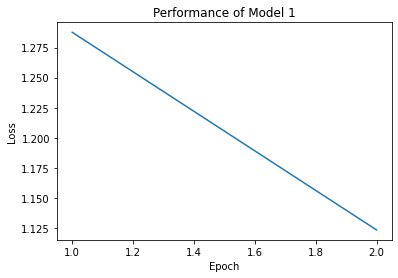

In [33]:
train_losslist = []
valid_loss_min = np.Inf

model.train()

for epoch in range(1,3):
    train_loss = 0.0
    for data, target in trainloader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    train_loss = train_loss/len(trainloader.dataset)
    train_losslist.append(train_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
    epoch, train_loss))

plt.plot([1,2], train_losslist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Performance of Model 1")
plt.show()

In [ ]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in testloader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(4):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))